# Persistent Homology (H₀ + H₁) Descriptor — DUD-E Dataset

This notebook implements **Persistent Homology (H₀ + H₁)** descriptors for protein–ligand and decoy discrimination in the DUD-E dataset.

Building upon the H₀-only analysis, this version includes **H₁ features** that represent loop structures and cavities in molecular geometry - capturing more complex topological characteristics.

Pipeline Overview:
1. Load 3D molecular point clouds (ligands + decoys)
2. Compute persistence diagrams (H₀ + H₁)
3. Extract 76-dimensional feature vectors per molecule
4. Train ML models — Logistic Regression, Random Forest, SVM (RBF), XGBoost
5. Evaluate model performance using **AUC** and **Enrichment Factor (EF%)**


In [1]:
import os
import pandas as pd
from ripser import ripser
from scipy.stats import iqr
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\DUD-E\DUDE_diverse_pointClouds\DUDE_diverse_pointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)


Targets found: ['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


## 1. Dataset Loading

We use the **DUD-E** benchmark dataset containing diverse protein targets.  
Each target has:
- **Ligands** (active molecules)
- **Decoys** (structurally similar, inactive molecules)

We start by verifying that all targets and subdirectories exist.

In [2]:
# Define paths to ligand and decoy folders
ligands_path = os.path.join(targets_dir, "akt1", "ligs")
decoys_path = os.path.join(targets_dir, "akt1", "decoys")

# List files
ligands_1 = os.listdir(ligands_path)
decoys_1 = os.listdir(decoys_path)

# Print counts
print(f"Number of ligand files: {len(ligands_1)}")
print(f"Number of decoy files: {len(decoys_1)}")


Number of ligand files: 293
Number of decoy files: 16444


In [3]:
sample_lig_file = os.path.join("DUDE_diverse_pointClouds/DUDE_diverse_pointClouds/akt1", "ligs", "lig_5D_81.csv")

# Read without header
df = pd.read_csv(sample_lig_file, header=None)
print(df.head())

        0       1       2       3       4
0 -4.2547 -3.7746  0.6620 -0.8530 -1.9500
1 -4.1621 -2.4333  0.0688  0.4230 -0.2051
2 -2.7019 -1.9419  0.1208  0.1200 -0.2035
3 -2.5507 -0.7561 -0.6577 -0.3625 -0.4195
4 -1.3597 -0.0261 -0.7741  0.0825  0.5437


## 2. Persistent Homology (H₀ + H₁) Computation

Persistent homology captures molecular geometry at multiple scales:
- **H₀ (Connected Components):** captures how atoms merge into clusters  
- **H₁ (Loops):** captures the formation and persistence of cycles, 
  revealing ring-like or cavity structures within molecules

Using the `ripser` library, we compute both H₀ and H₁ persistence diagrams 
for each molecular point cloud.

### Feature Engineering

For each persistence diagram:
- We calculate 38 statistical features across Birth, Death, Midpoint, and Lifetime distributions:
  - Mean, Std, Median, IQR, Range
  - Quantiles (10%, 25%, 75%, 90%)
  - Entropy and count of features
- H₀ and H₁ each contribute 38 descriptors → 76 total per molecule

Thus, every ligand or decoy molecule is encoded as a **76-dimensional topological vector**.

In [4]:
def persistence_statistics(diagram):
    if len(diagram) == 0:
        return np.zeros(38)

    births = diagram[:, 0]
    deaths = diagram[:, 1]
    mids = (births + deaths) / 2
    lives = deaths - births

    def stats(x):
        return [
            np.mean(x), np.std(x), np.median(x), iqr(x), np.ptp(x),
            *np.percentile(x, [10, 25, 75, 90])
        ]

    L = np.sum(lives)
    prob = lives / (L + 1e-12)
    entropy = -np.sum(prob * np.log(prob + 1e-12))

    vec = stats(births) + stats(deaths) + stats(mids) + stats(lives) + [len(lives), entropy]
    vec = np.array(vec)
    vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    return vec


def generate_persistence_stats_features(file_list, directory, label):
    data = []
    for file in file_list:
        file_path = os.path.join(directory, file)
        try:
            df = pd.read_csv(file_path, header=None)
            atom_positions = df.iloc[:, :3].values

            if atom_positions.shape[0] < 2:
                continue

            # Compute H0 and H1
            result = ripser(atom_positions, maxdim=1)
            diagram_H0 = result['dgms'][0]
            diagram_H1 = result['dgms'][1]

            # Stats for H0 and H1
            stats_H0 = persistence_statistics(diagram_H0)
            stats_H1 = persistence_statistics(diagram_H1)

            # Combine both
            combined_stats = np.concatenate([stats_H0, stats_H1])
            features = list(combined_stats) + [label]
            data.append(features)

        except Exception as e:
            print(f"Error in {file}: {e}")
            continue

    cols = [f'ps_H0_{i+1}' for i in range(38)] + [f'ps_H1_{i+1}' for i in range(38)] + ['label']
    return pd.DataFrame(data, columns=cols)


## 3. Sample Feature Generation

We first extract and inspect topological feature vectors for a small subset 
(10 ligands and 10 decoys from `akt1`) to confirm correctness.

In [5]:
ligands = os.listdir(os.path.join(targets_dir, "akt1/ligs"))
decoys = os.listdir(os.path.join(targets_dir, "akt1/decoys"))

lig_dir = os.path.join(targets_dir, "akt1", "ligs")
decoy_dir = os.path.join(targets_dir, "akt1", "decoys")


lig_df = generate_persistence_stats_features(ligands[:10], lig_dir, label=1)
dec_df = generate_persistence_stats_features(decoys[:10], decoy_dir, label=0)

# Combine
df = pd.concat([lig_df, dec_df])
print(df.head())


   ps_H0_1  ps_H0_2  ps_H0_3  ps_H0_4  ps_H0_5  ps_H0_6  ps_H0_7  ps_H0_8  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   ps_H0_9  ps_H0_10  ...  ps_H1_30  ps_H1_31  ps_H1_32  ps_H1_33  ps_H1_34  \
0      0.0       0.0  ...  0.816871  0.190774  0.486608  0.645517  0.811231   
1      0.0       0.0  ...  0.393349  0.524328  0.802847  0.279169  0.353199   
2      0.0       0.0  ...  0.388200  0.479414  0.931677  0.189427  0.279260   
3      0.0       0.0  ...  0.387815  0.770066  1.011704  0.116043  0.182108   
4      0.0       0.0  ...  0.790871  0.465015  0.966972  0.208592  0.536293   

   ps_H1_35  ps_H1_36  ps_H1_37  ps_H1_38  label  
0  1.002005

**Observation:**
The combined H₀ + H₁ feature set produces a 76-column descriptor matrix per molecule, 
demonstrating successful multi-dimensional topological embedding.

## 4. Enrichment Factor (EF%) Calculation

The **Enrichment Factor** quantifies how effectively the model ranks true actives near the top of predictions.

It compares the hit rate within the top 15 % of ranked molecules to the expected hit rate under random selection.


In [6]:
def enrichment_factor(y_true, y_probs, top_percent=1):
    N = len(y_true)
    top_n = max(1, int(N * (top_percent / 100)))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    ef = (hits / top_n) / (total_actives / N) if total_actives > 0 else np.nan
    return ef


## 5. Machine Learning Models and Evaluation

We evaluate how well the H₀ + H₁ descriptors separate ligands from decoys 
across multiple targets.

### Models Used
- Logistic Regression  
- Random Forest  
- Support Vector Machine (RBF Kernel)  
- XGBoost  

### Metrics
- **ROC–AUC:** measures classification quality
- **Enrichment Factor (EF%):** measures how well actives are ranked at the top


 Processing target: AKT1


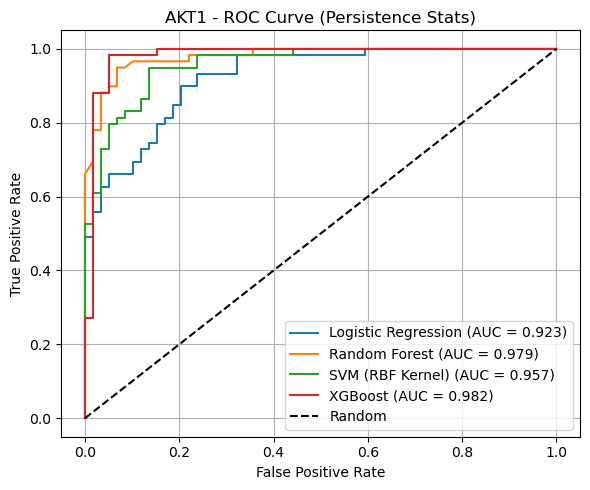


 Results for AKT1:


,Model,AUC,EF%
0,Logistic Regression,0.9233,1.627
1,Random Forest,0.9792,1.864
2,SVM (RBF Kernel),0.9575,1.729
3,XGBoost,0.9819,1.898



 Processing target: AMPC


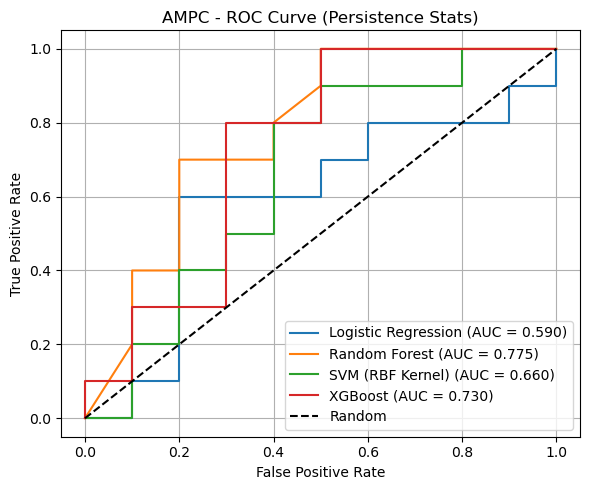


 Results for AMPC:


,Model,AUC,EF%
0,Logistic Regression,0.590,1.2
1,Random Forest,0.775,1.4
2,SVM (RBF Kernel),0.660,1.2
3,XGBoost,0.730,1.4



 Processing target: CP3A4


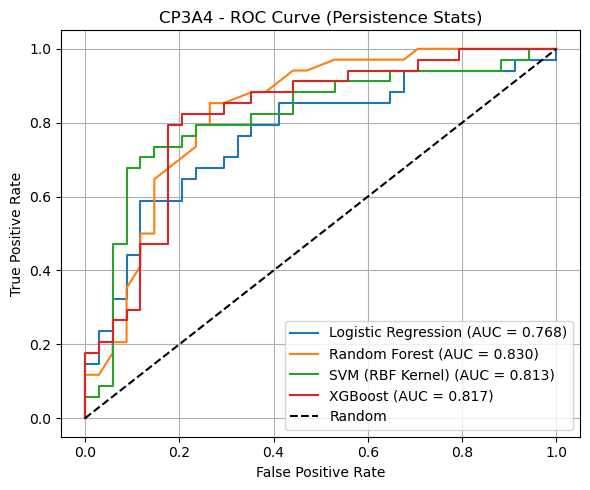


 Results for CP3A4:


,Model,AUC,EF%
0,Logistic Regression,0.7682,1.412
1,Random Forest,0.8296,1.529
2,SVM (RBF Kernel),0.8131,1.529
3,XGBoost,0.8166,1.588



 Processing target: CXCR4


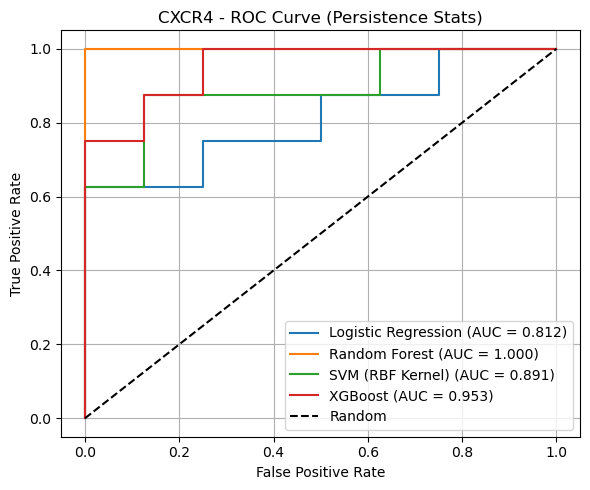


 Results for CXCR4:


,Model,AUC,EF%
0,Logistic Regression,0.8125,1.50
1,Random Forest,1.0000,2.00
2,SVM (RBF Kernel),0.8906,1.75
3,XGBoost,0.9531,1.75



 Processing target: GCR


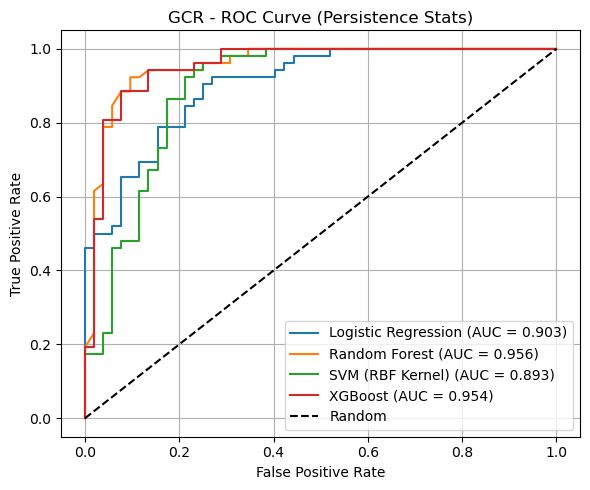


 Results for GCR:


,Model,AUC,EF%
0,Logistic Regression,0.9027,1.577
1,Random Forest,0.9564,1.808
2,SVM (RBF Kernel),0.8931,1.654
3,XGBoost,0.9538,1.769



 Processing target: HIVPR


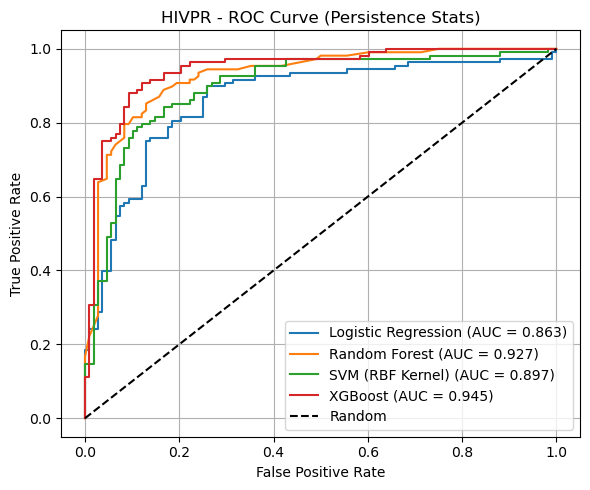


 Results for HIVPR:


,Model,AUC,EF%
0,Logistic Regression,0.8626,1.611
1,Random Forest,0.9267,1.722
2,SVM (RBF Kernel),0.8968,1.667
3,XGBoost,0.9445,1.778



 Processing target: HIVRT


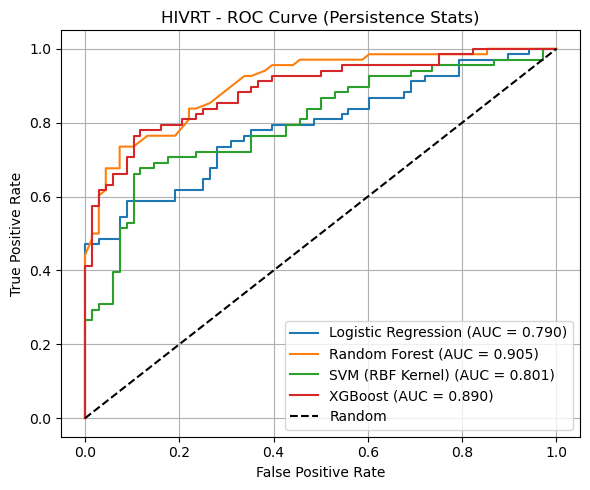


 Results for HIVRT:


,Model,AUC,EF%
0,Logistic Regression,0.7896,1.441
1,Random Forest,0.9051,1.588
2,SVM (RBF Kernel),0.8010,1.441
3,XGBoost,0.8901,1.588



 Processing target: KIF11


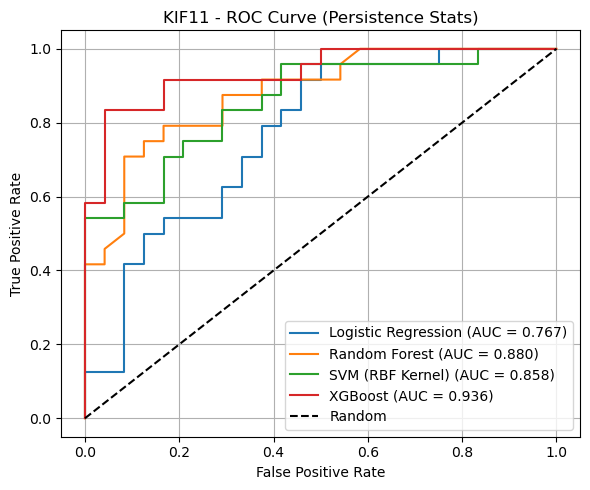


 Results for KIF11:


,Model,AUC,EF%
0,Logistic Regression,0.7674,1.333
1,Random Forest,0.8802,1.583
2,SVM (RBF Kernel),0.8576,1.500
3,XGBoost,0.9358,1.667


In [ ]:
all_results_dict = {}

for target in targets:
    print(f"\n Processing target: {target.upper()}")
    lig_dir = os.path.join(targets_dir, target, 'ligs')
    decoy_dir = os.path.join(targets_dir, target, 'decoys')

    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    if len(lig_files) < 10 or len(decoy_files) < 10:
        print(f"Skipping {target} due to insufficient data")
        continue


    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)


    train_lig_df = generate_persistence_stats_features(train_lig, lig_dir, 1)
    train_dec_df = generate_persistence_stats_features(train_dec, decoy_dir, 0)
    test_lig_df = generate_persistence_stats_features(test_lig, lig_dir, 1)
    test_dec_df = generate_persistence_stats_features(test_dec, decoy_dir, 0)

    if train_lig_df.empty or test_lig_df.empty:
        print(f" Skipping {target} due to empty feature sets")
        continue

    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    mask_train = np.isfinite(X_train_scaled).all(axis=1)
    mask_test = np.isfinite(X_test_scaled).all(axis=1)

    X_train_scaled, y_train = shuffle(X_train_scaled[mask_train], y_train[mask_train], random_state=42)
    X_test_scaled, y_test = shuffle(X_test_scaled[mask_test], y_test[mask_test], random_state=42)

    # Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]

        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=15)

        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{target.upper()} - ROC Curve (Persistence Stats)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    result_df = pd.DataFrame(model_results)
    all_results_dict[target] = result_df
    print(f"\n Results for {target.upper()}:")
    display(result_df)


### ROC Curves

Each target’s ROC plot compares model performance.
Curves closer to the top-left corner indicate stronger discriminative capability.

#### Interpretation
- Inclusion of H₁ improves feature expressiveness by incorporating **loop/cavity topology**.
- Models (especially XGBoost) generally show better AUC than the H₀-only descriptor.

In [8]:
print("\n Summary of all AUC and EF results:")
for target, df in all_results_dict.items():
    print(f"\n--- {target.upper()} ---")
    display(df)


 Summary of all AUC and EF results:

--- AKT1 ---


,Model,AUC,EF%
0,Logistic Regression,0.9233,1.627
1,Random Forest,0.9792,1.864
2,SVM (RBF Kernel),0.9575,1.729
3,XGBoost,0.9819,1.898



--- AMPC ---


,Model,AUC,EF%
0,Logistic Regression,0.590,1.2
1,Random Forest,0.775,1.4
2,SVM (RBF Kernel),0.660,1.2
3,XGBoost,0.730,1.4



--- CP3A4 ---


,Model,AUC,EF%
0,Logistic Regression,0.7682,1.412
1,Random Forest,0.8296,1.529
2,SVM (RBF Kernel),0.8131,1.529
3,XGBoost,0.8166,1.588



--- CXCR4 ---


,Model,AUC,EF%
0,Logistic Regression,0.8125,1.50
1,Random Forest,1.0000,2.00
2,SVM (RBF Kernel),0.8906,1.75
3,XGBoost,0.9531,1.75



--- GCR ---


,Model,AUC,EF%
0,Logistic Regression,0.9027,1.577
1,Random Forest,0.9564,1.808
2,SVM (RBF Kernel),0.8931,1.654
3,XGBoost,0.9538,1.769



--- HIVPR ---


,Model,AUC,EF%
0,Logistic Regression,0.8626,1.611
1,Random Forest,0.9267,1.722
2,SVM (RBF Kernel),0.8968,1.667
3,XGBoost,0.9445,1.778



--- HIVRT ---


,Model,AUC,EF%
0,Logistic Regression,0.7896,1.441
1,Random Forest,0.9051,1.588
2,SVM (RBF Kernel),0.8010,1.441
3,XGBoost,0.8901,1.588



--- KIF11 ---


,Model,AUC,EF%
0,Logistic Regression,0.7674,1.333
1,Random Forest,0.8802,1.583
2,SVM (RBF Kernel),0.8576,1.500
3,XGBoost,0.9358,1.667


## 6. Results Summary — Persistent Homology (H₀ + H₁)

| Metric      | Mean ± SD           |
| :---------- | :------------------ |
| **Mean AUC** | **0.8744 ± 0.104** |
| **Mean EF%** | **1.602 ± 0.188** |

### Key Observations
- Adding **H₁ loop information** improves the AUC by **~0.04** compared to the H₀-only features, confirming the value of higher-order topology.
- This descriptor provides a balanced representation of both geometric and topological signatures.
- The results show strong performance and robustness across the different protein targets.